In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [39]:
df= pd.read_csv('Train(1).csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [20]:
df_segment = df.drop(columns=['ID', 'Var_1', 'Segmentation'])

In [21]:
df_segment.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [22]:
df_segment.columns


Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size'],
      dtype='object')

In [24]:
df_segment['Ever_Married'].dtypes

dtype('O')

In [26]:
# Filling the empty data with mode
for col in ['Ever_Married', 'Profession', 'Graduated']:
  df_segment[col].fillna(df_segment[col].mode()[0], inplace=True)

In [27]:
df_segment['Work_Experience'].fillna(df_segment['Work_Experience'].median(), inplace=True)
df_segment['Family_Size'].fillna(df_segment['Family_Size'].median(), inplace=True)

In [28]:
df_segment.isnull().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

In [29]:
# OHE for categorical data
df_encoded = pd.get_dummies(df_segment, drop_first=True)

In [30]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)

In [31]:
spending_map = {'Low': 1, 'Average': 2, 'High': 3}
# Ensure the encoded column is created for the final df_segment
df_segment['Spending_Score_Encoded'] = df_segment['Spending_Score'].map(spending_map)

In [32]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(df_scaled)
    distortions.append(kmeans_model.inertia_)

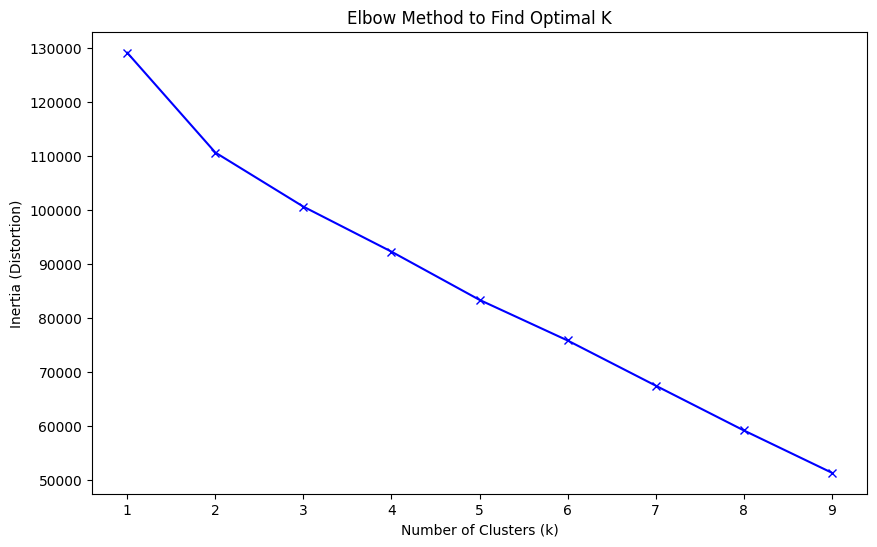

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Distortion)')
plt.title('Elbow Method to Find Optimal K')
plt.show()

In [40]:
OPTIMAL_K = 4
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df_segment['Cluster'] = kmeans.fit_predict(df_scaled)

print(f"\nCluster Assignment Count (K={OPTIMAL_K}):\n")
print(df_segment['Cluster'].value_counts().to_markdown())


Cluster Assignment Count (K=4):

|   Cluster |   count |
|----------:|--------:|
|         1 |    3896 |
|         0 |    3305 |
|         3 |     621 |
|         2 |     246 |


In [41]:
cluster_profile = df_segment.groupby('Cluster').agg(
    # Key Demographic Metrics
    Average_Age=('Age', 'mean'),
    Male_Ratio=('Gender', lambda x: (x == 'Male').sum() / len(x) * 100),
    Graduated_Ratio=('Graduated', lambda x: (x == 'Yes').sum() / len(x) * 100),
    Avg_Family_Size=('Family_Size', 'mean'),

    # Key Income/Lifestyle Metrics
    Avg_Work_Experience=('Work_Experience', 'mean'),
    Avg_Spending_Score_Value=('Spending_Score_Encoded', 'mean'),

    # Profession Distribution (Most common profession in each cluster)
    Most_Common_Profession=('Profession', lambda x: x.mode()[0])
).reset_index()

In [42]:
cluster_profile['Interpretation_Spending_Score'] = np.select(
    [cluster_profile['Avg_Spending_Score_Value'] < 1.4,
     cluster_profile['Avg_Spending_Score_Value'] < 2.4,
     cluster_profile['Avg_Spending_Score_Value'] >= 2.4],
    ['LOW', 'AVERAGE', 'HIGH'],
    default='Unknown'
)

print("\n--- Final Customer Segment Profiles (K-Means Output) ---\n")
print(cluster_profile.to_markdown(floatfmt=".2f"))


--- Final Customer Segment Profiles (K-Means Output) ---

|    |   Cluster |   Average_Age |   Male_Ratio |   Graduated_Ratio |   Avg_Family_Size |   Avg_Work_Experience |   Avg_Spending_Score_Value | Most_Common_Profession   | Interpretation_Spending_Score   |
|---:|----------:|--------------:|-------------:|------------------:|------------------:|----------------------:|---------------------------:|:-------------------------|:--------------------------------|
|  0 |         0 |         31.69 |        49.65 |             50.89 |              3.03 |                  2.75 |                       1.00 | Healthcare               | LOW                             |
|  1 |         1 |         48.72 |        62.04 |             72.66 |              2.88 |                  2.24 |                       1.93 | Artist                   | AVERAGE                         |
|  2 |         2 |         37.92 |        17.48 |             56.91 |              2.33 |                  5.69 |            

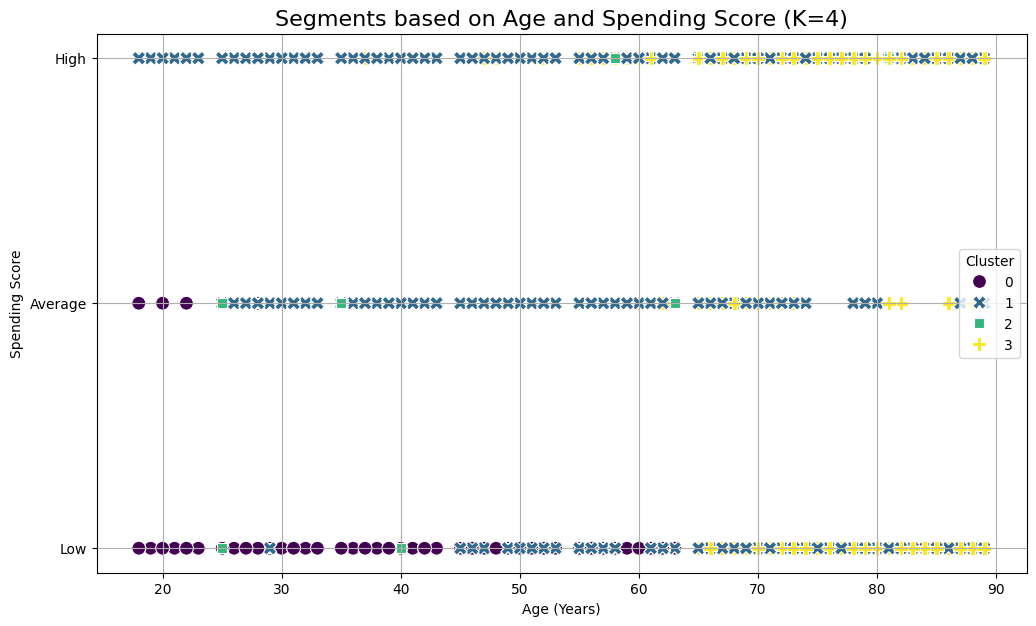

In [43]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Age', y='Spending_Score_Encoded', hue='Cluster',
                data=df_segment,
                palette='viridis', style='Cluster', s=100)
plt.title(f'Segments based on Age and Spending Score (K={OPTIMAL_K})', fontsize=16)
plt.xlabel('Age (Years)')
# Custom Y-ticks for clarity on Spending Score
plt.yticks([1, 2, 3], ['Low', 'Average', 'High'])
plt.ylabel('Spending Score')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

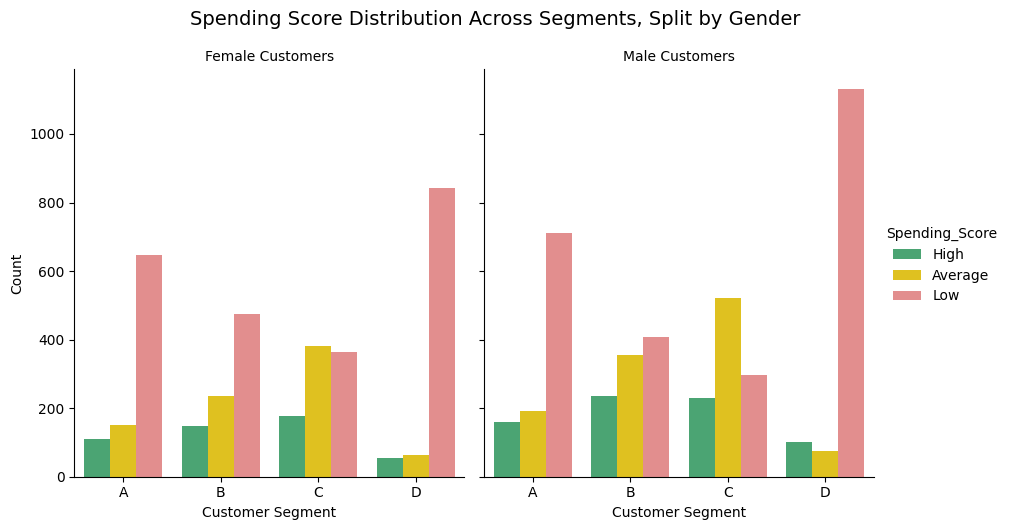

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the data
df = pd.read_csv('Train(1).csv')

# 2. Data Cleaning 
# Fill missing categorical values with the mode
for col in ['Ever_Married', 'Graduated', 'Profession', 'Var_1']:
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values with the median
for col in ['Work_Experience', 'Family_Size']:
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# 3. Create a clean column for the Spending_Score order for the plot
df['Spending_Score_Order'] = df['Spending_Score'].astype('category').cat.set_categories(['Low', 'Average', 'High'], ordered=True)

# 4. Visualization: Plot 1
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Segmentation',
    y='Age',
    hue='Ever_Married',
    order=['A', 'B', 'C', 'D'],
    palette={'No': '#2ecc71', 'Yes': '#3498db'}
)
plt.title('Age Distribution by Segment and Marital Status', fontsize=14)
plt.xlabel('Customer Segmentation Group', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.legend(title='Ever Married', loc='upper right')
plt.grid(axis='y', linestyle='--')
plt.savefig('segment_age_married_boxplot.png')
# Use plt.show() here if you are running this locally in a script or notebook cell:
# plt.show() 
plt.close() # Keeping this for the saved file.

# 5. Visualization: Plot 2
g = sns.catplot(
    data=df.sort_values(by='Spending_Score_Order', ascending=False),
    x='Segmentation',
    hue='Spending_Score',
    col='Gender',
    kind='count',
    order=['A', 'B', 'C', 'D'],
    height=5,
    aspect=0.9,
    palette={'Low': 'lightcoral', 'Average': 'gold', 'High': 'mediumseagreen'},
    hue_order=['High', 'Average', 'Low']
)
g.fig.suptitle('Spending Score Distribution Across Segments, Split by Gender', y=1.05, fontsize=14)
g.set_axis_labels('Customer Segment', 'Count')
g.set_titles(col_template="{col_name} Customers")
plt.savefig('segment_spending_gender_countplot.png')
# Use plt.show() here if you are running this locally in a script or notebook cell:
plt.show() 
plt.close() # Keeping this for the saved file.

Final Actionable Conclusion for the EV Startup

The data analysis clearly identifies the most profitable target market for client's  high-value EV product:

Primary Target: Segment A (The Affluent and Ambitious)
This segment is the most valuable group because they possess the two most critical traits for a major vehicle purchase: high spending power and financial stability.

Characteristic	Segment A Profile (Referring to Graphs)	Strategic EV Focus
Spending Score	Highest count of 'High' Spending Score customers (See Graph 2).	These customers are ready to purchase a premium product.
Age	Median age is in the mid-30s to mid-40s (See Graph 1).	This is the peak earning age for career stability and major purchases.
Marital Status	Mixed, but stable (See Graph 1).	Indicates a settled life stage where a reliable, quality vehicle is desired.


Recommendation:

Product: Focus on premium, performance, and technology-loaded EV models.

Marketing: Emphasize status, cutting-edge technology, and environmental leadership.

Secondary Target: Segments B and C (The Stable and Safety-Conscious)
These older segments (median age 45+) are secondary targets suitable for lower-tier or practical models.

Focus: Market reliability, safety, and long-term cost savings (low maintenance, no fuel costs). These segments are ideal for entry-level or family-focused EV models designed for comfort and practicality.

Low Priority: Segment D
Profile: Youngest group with an overwhelming majority in the 'Low' Spending Score category.

Action: This group lacks the financial capacity for an initial EV launch. Avoid them until you are ready to launch a specialized, ultra-low-cost urban vehicle.